Generate hourly prediction for future data by simply averaging historical data, and scale it according to the weekly prediction provided.

# Preparation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv, find_dotenv
import sys
sys.path.append('../')

In [2]:
# data directories
load_dotenv(find_dotenv(), verbose=True)
dir_project = os.getenv('PROJECT_ROOT')
dir_data_raw = os.path.join(dir_project, 'data/raw/')
dir_data_interim = os.path.join(dir_project, 'data/interim/')
dir_data_processed = os.path.join(dir_project, 'data/processed/')
dir_data_external = os.path.join(dir_project, 'data/external/')
dir_models = os.path.join(dir_project, 'models/')

Load data:  

In [3]:
path_data = os.path.join(dir_data_interim, 'Clean_Hourly_Data.csv')

In [4]:
df_origin = pd.read_csv(path_data)
df_origin.Date = pd.to_datetime(df_origin.Date + ' ' + df_origin.Hour)
df_origin.set_index('Date', inplace=True)

In [5]:
df_origin.head()

,Hour,HOEP,Ontario.Demand,NUCLEAR,GAS,HYDRO,WIND,SOLAR,BIOFUEL,Temp,Holidays,season_Fall,season_Spring,season_Summer,season_Winter,month,dayofweek,CDD,HDD
Date,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,00:00:00,3.28,14960,11564,957,3173,2504,0.0,20,-6.2,1,0,0,0,1,1,3,0.0,24.53
2015-01-01 01:00:00,01:00:00,0.00,14476,11560,946,3100,2262,0.0,20,-6.0,1,0,0,0,1,1,3,0.0,24.33
2015-01-01 02:00:00,02:00:00,0.00,13979,11560,947,3051,2025,0.0,20,-6.2,1,0,0,0,1,1,3,0.0,24.53
2015-01-01 03:00:00,03:00:00,0.00,13670,11444,949,3086,1950,0.0,22,-6.0,1,0,0,0,1,1,3,0.0,24.33
2015-01-01 04:00:00,04:00:00,0.00,13567,11174,946,3131,2015,0.0,21,-6.0,1,0,0,0,1,1,3,0.0,24.33


In [6]:
len(df_origin)

48360

In [7]:
independ_vars = ['HOEP', 'Ontario.Demand', 'Temp', 'NUCLEAR', 'GAS', 'HYDRO', 'WIND', 'SOLAR', 'BIOFUEL']
df = df_origin[independ_vars]

Leave `CDD`, `HDD` aside since it's calculated from `Temp`.

Missing `dew point` in the data.

# Split Data

In [36]:
df_train = df[df.index.year < 2019].copy()
df_test = df[df.index.year >= 2019].copy()

In [37]:
print(f'Train/Test: {len(df_train)}/{len(df_test)}')
print('Test%:', len(df_test)/len(df))

Train/Test: 35064/13296
Test%: 0.2749379652605459


# Average hourly data

Since the largest seasonality is annual, we will split historical data into years and average the data of every hour in the year.  
So we will index by Month/Year/Hour:

In [38]:
df_train['Month'] = df_train.index.month
df_train['Day'] = df_train.index.day
df_train['Hour'] = df_train.index.hour

df_train.set_index(['Month', 'Day', 'Hour'], inplace=True)

In [39]:
df_train

HOEP  Ontario.Demand  Temp  NUCLEAR  GAS  HYDRO  WIND  SOLAR  \
Month Day Hour                                                                 
1     1   0     3.28           14960  -6.2    11564  957   3173  2504    0.0   
          1     0.00           14476  -6.0    11560  946   3100  2262    0.0   
          2     0.00           13979  -6.2    11560  947   3051  2025    0.0   
          3     0.00           13670  -6.0    11444  949   3086  1950    0.0   
          4     0.00           13567  -6.0    11174  946   3131  2015    0.0   
...              ...             ...   ...      ...  ...    ...   ...    ...   
12    31  19    5.62           16195   3.2    11200  229   4094  2303    0.0   
          20    8.95           15668   3.6    11188  230   3710  2581    0.0   
          21    5.81           14987   4.0    11187  232   3482  2299    0.0   
          22    2.87           14560   4.0    11212  233   3254  2506    0.0   
          23    0.00           13828   4.0    11219  232   3136  1897    0.0   

                BIOFUEL  
Month Day Hour           
1     1   0          20  
          1          20  
          2          20  
          3          22  
          4          21  
...                 ...  
12    31  19         27  
          20         27  
          21         27  
          22         27  
          23         16  

[35064 rows x 9 columns]

In [40]:
df_average = df_train.mean(level=[0,1,2])
df_average

HOEP  Ontario.Demand   Temp   NUCLEAR      GAS    HYDRO  \
Month Day Hour                                                               
1     1   0     13.3700        14631.50 -4.950  11503.75   923.25  3193.50   
          1     10.2950        14161.25 -5.100  11461.00   822.75  3178.75   
          2     22.3425        13764.00 -5.425  11433.00   785.25  3189.50   
          3     12.5950        13557.00 -5.475  11287.00   787.00  3120.00   
          4      2.4775        13429.00 -5.300  11217.50   776.50  2977.00   
...                 ...             ...    ...       ...      ...      ...   
2     29  19     0.0000        18853.00 -1.800  11357.00  1181.00  5409.00   
          20     4.8200        18701.00 -4.000  11358.00  1176.00  5335.00   
          21     1.7900        18022.00 -4.800  11357.00  1169.00  5179.00   
          22     0.9700        17083.00 -5.300  11358.00  1170.00  5012.00   
          23     6.0300        16224.00 -5.600  11358.00   991.00  4825.00   

                   WIND  SOLAR  BIOFUEL  
Month Day Hour                           
1     1   0     1796.00    0.0     6.75  
          1     1715.75    0.0     6.25  
          2     1517.50    0.0     7.25  
          3     1513.00    0.0     7.50  
          4     1592.25    0.0     6.00  
...                 ...    ...      ...  
2     29  19    2683.00    0.0     0.00  
          20    2756.00    0.0     0.00  
          21    2273.00    0.0     0.00  
          22    1910.00    0.0     0.00  
          23    1533.00    0.0     0.00  

[8784 rows x 9 columns]

8784 = 366*24 since there are 366 days in year 2016 (leap year).

# Visualize

The historical (train) data is from 2015/01/01 to 2018/12/31.

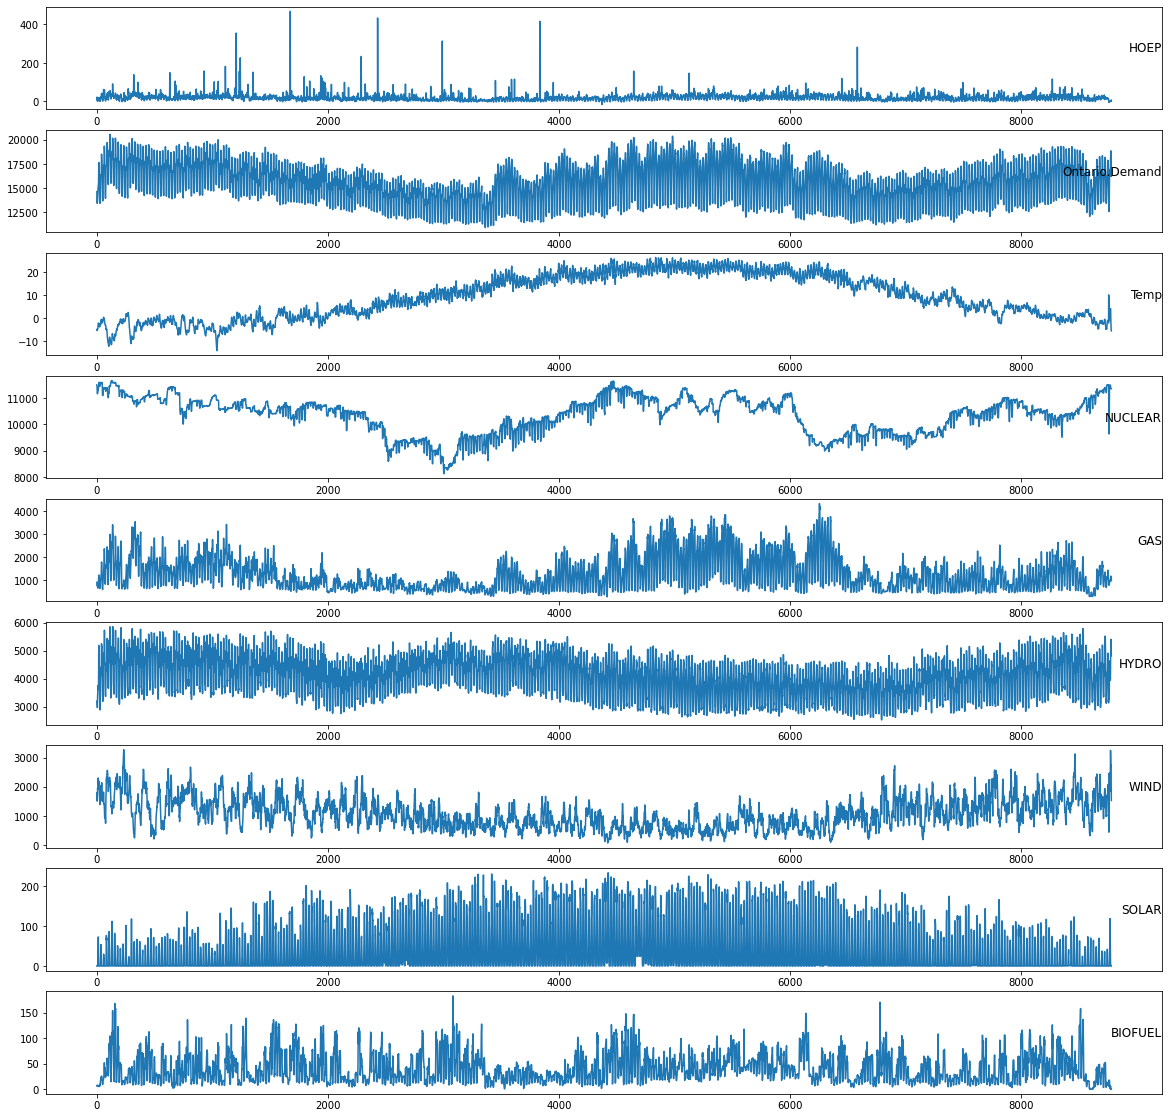

In [17]:
values = df_average.values
# specify columns to plot
cols = range(0, values.shape[1])
i = 1
# plot each column
plt.figure(figsize=(20, 20))
for col in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, col])
	plt.title(df.columns[col], y=0.5, loc='right')
	i += 1
plt.show()

Take year 2016 as comparison:

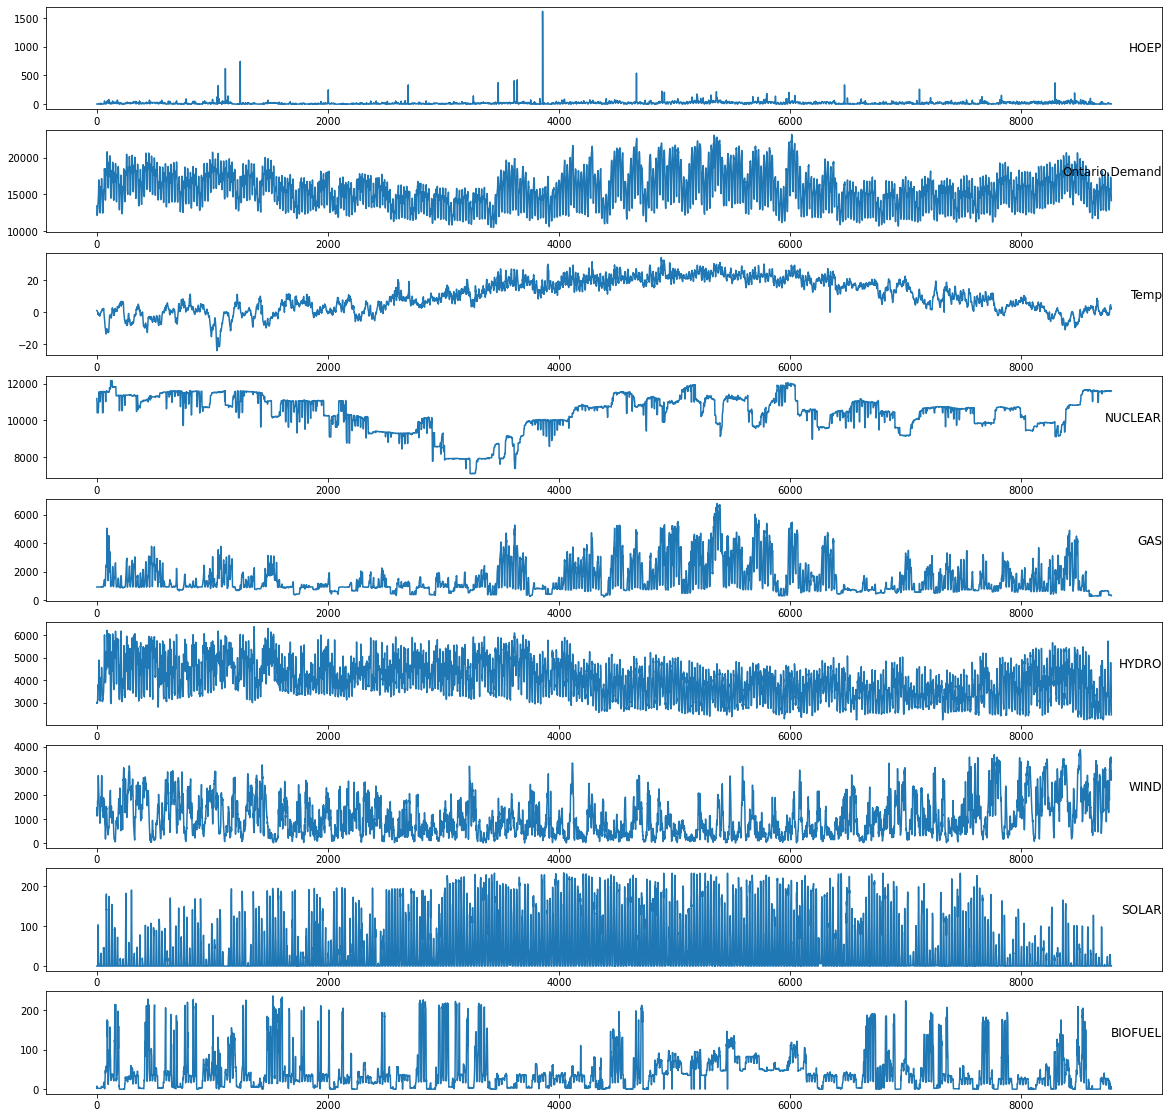

In [63]:
values_2016 = df[df.index.year==2016].values
# specify columns to plot
cols = range(0, values.shape[1])
i = 1
# plot each column
plt.figure(figsize=(20, 20))
for col in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values_2016[:, col])
	plt.title(df.columns[col], y=0.5, loc='right')
	i += 1
plt.show()

- One month sample data:

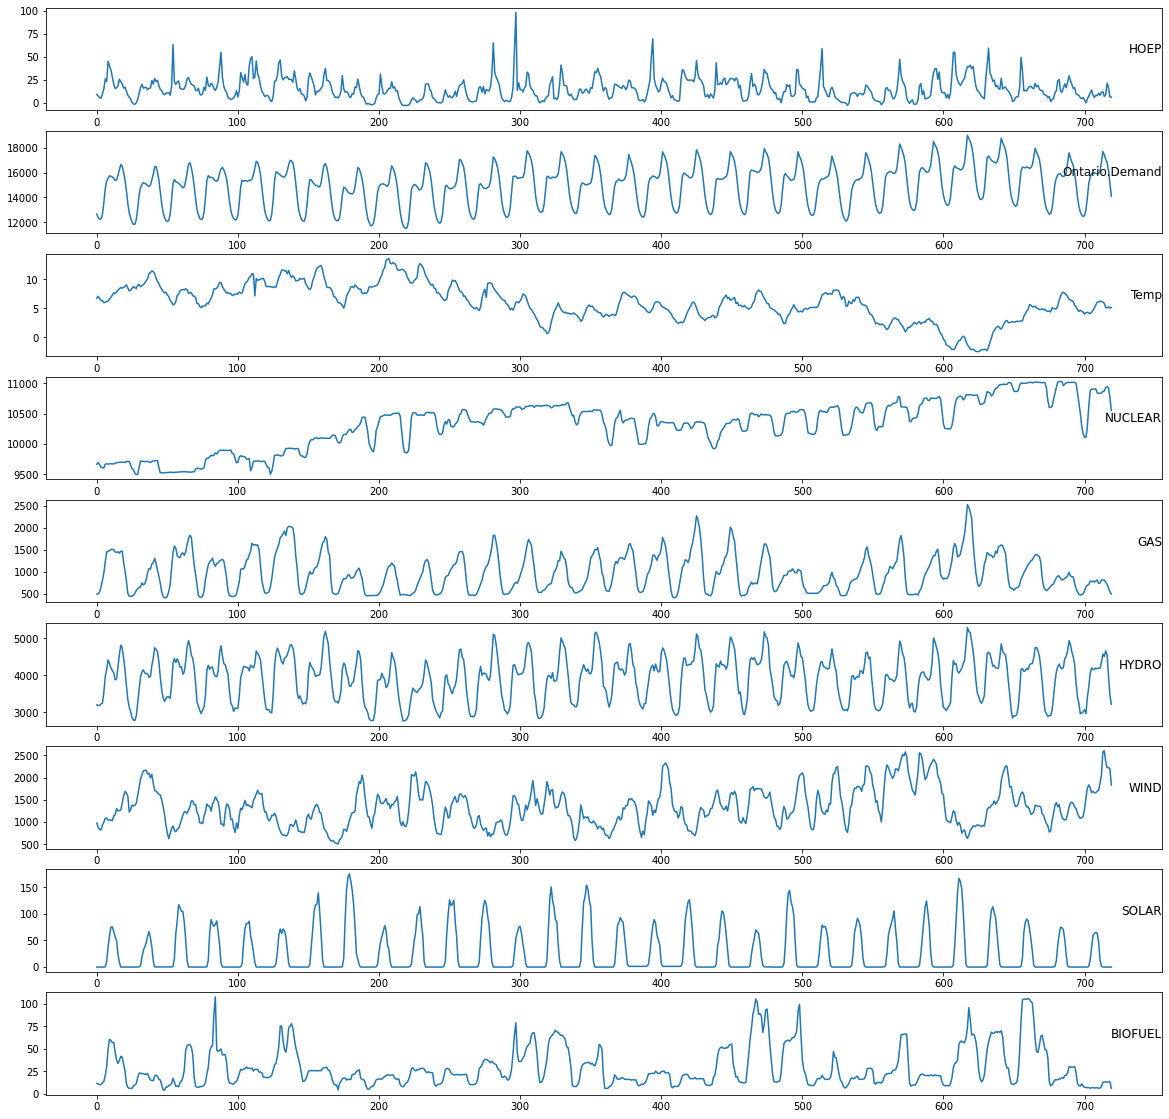

In [59]:
cols = range(0, values.shape[1])
i = 1
# plot each column
plt.figure(figsize=(20, 20))
for col in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[720*10:720*11, col])
	plt.title(df.columns[col], y=0.5, loc='right')
	i += 1
plt.show()

Take one month from 2016:

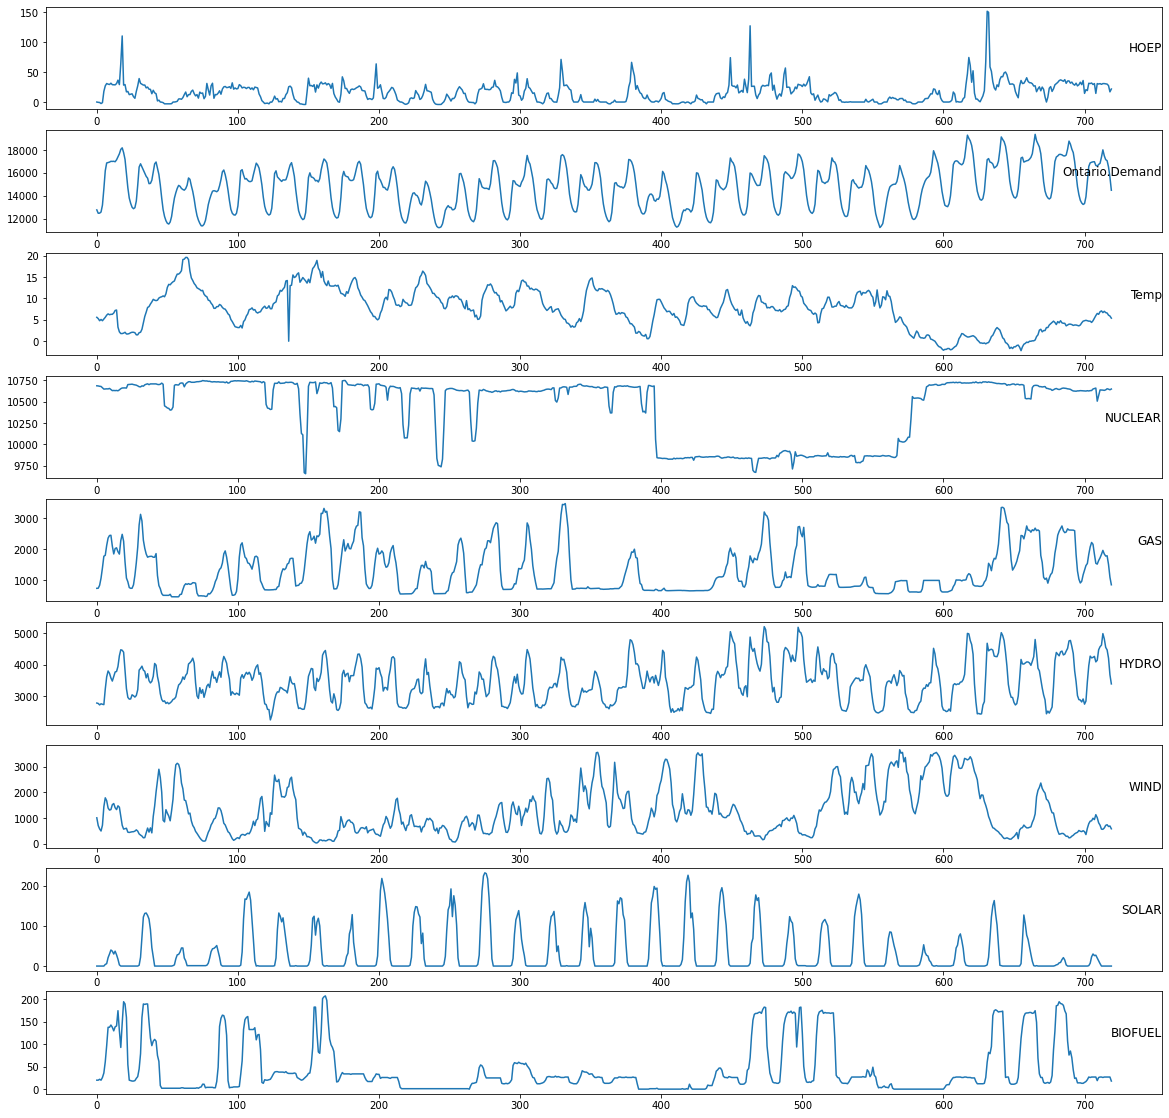

In [66]:
cols = range(0, values_2016.shape[1])
i = 1
# plot each column
plt.figure(figsize=(20, 20))
for col in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values_2016[720*10:720*11, col])
	plt.title(df.columns[col], y=0.5, loc='right')
	i += 1
plt.show()

- One day sample:

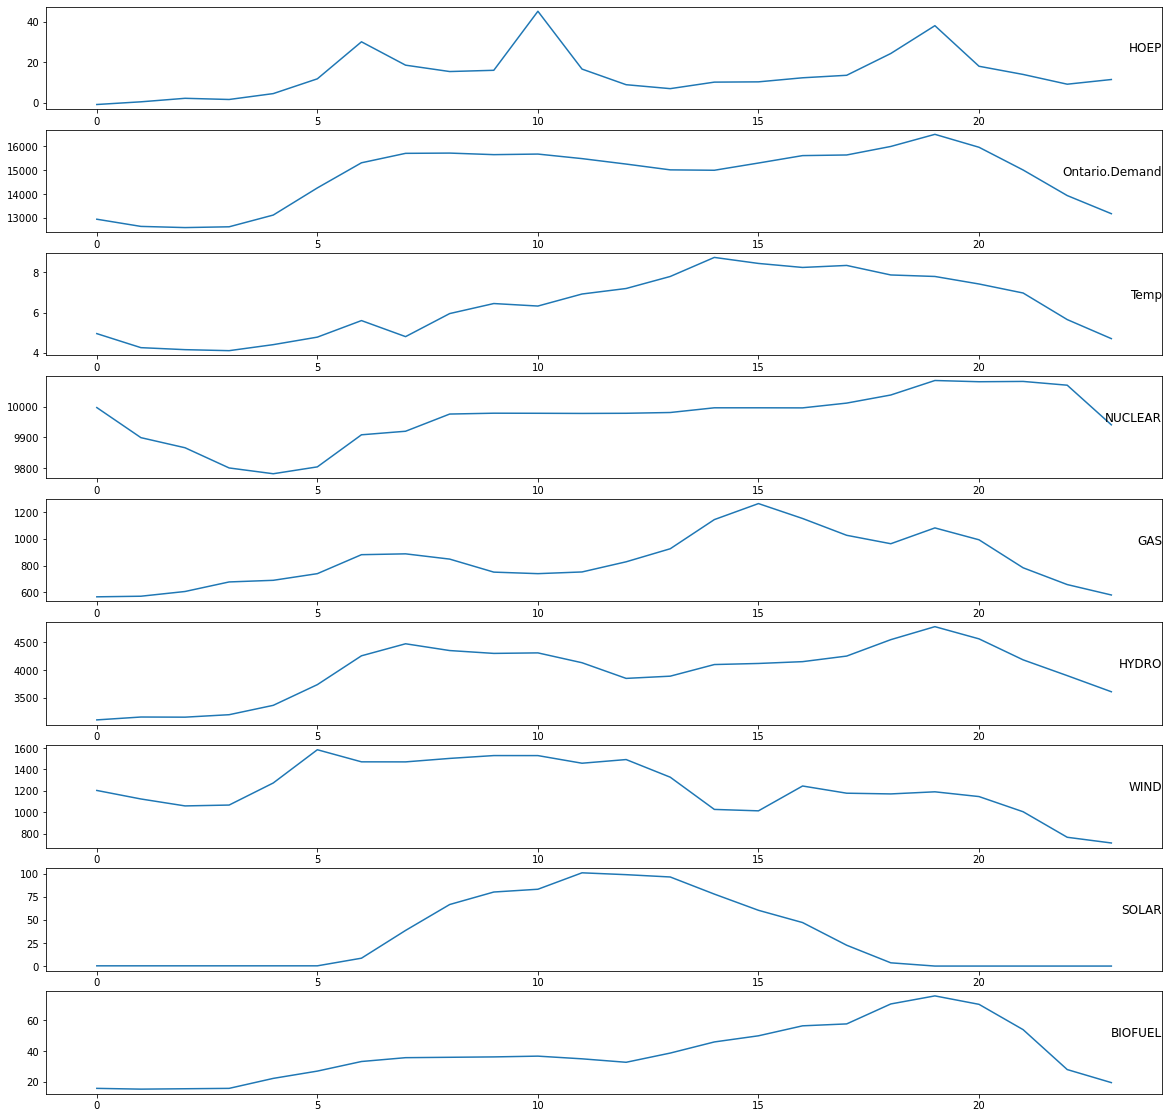

In [60]:
cols = range(0, values.shape[1])
i = 1
# plot each column
plt.figure(figsize=(20, 20))
for col in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[24*100:24*101, col])
	plt.title(df.columns[col], y=0.5, loc='right')
	i += 1
plt.show()

We can find clear seasonnal and daily patterns on most of the variables.

One thing that misses is this average **doesn't count weekly pattern**, nor does it capture some holiday information.

- Output:

In [67]:
df_average.to_csv(os.path.join(dir_data_processed, 'hourly_data_from_historical_average.csv'))

# Scale by weekly outlook

## Load the weekly outlook:

In [120]:
df_outlook_origin = pd.read_excel(os.path.join(dir_data_raw, 'Data 18 months Outlook/12-01-2018/12012018.xlsx'), sheet_name='Feuil1')
independ_vars = ['Ontario ED', 'Normal Average Temperature (°C)', 'Expected Nuclear Output', 
                 'Expected Hydro Output', 'Expected Wind Output', 'Expected Self-Scheduling & Intermittent Output']
df_outlook = df_outlook_origin[['Date (week ending)', 'HOEP'] + independ_vars].copy()

In [121]:
df_outlook.head(2)

,Date (week ending),HOEP,Ontario ED,Normal Average Temperature (°C),Expected Nuclear Output,Expected Hydro Output,Expected Wind Output,Expected Self-Scheduling & Intermittent Output
0,2019-01-06 23:00:00,13.066012,2616.954613,-4.533333,10800,2756,1693.698047,78.546684
1,2019-01-13 23:00:00,20.495655,2883.187716,-7.480952,10815,2756,1693.698047,78.870922


In [122]:
df_outlook['Week'] = df_outlook['Date (week ending)'].apply(lambda x: x.isocalendar()[1])

Average Demand into hourly:

In [123]:
# GWh -> MWh, need *1000
df_outlook['Ontario ED'] = df_outlook['Ontario ED']*1000/168

Rename cols to match the other df:

In [166]:
df_outlook.rename(columns={"Ontario ED": "Ontario.Demand", "Normal Average Temperature (°C)": "Temp", 
                          'Expected Nuclear Output': 'NUCLEAR', 'Expected Hydro Output': 'HYDRO', 
                          'Expected Wind Output': 'WIND', 'Expected Self-Scheduling & Intermittent Output': 'Intermittent_Output'}, 
                  inplace = True)

In [175]:
independ_vars = df_outlook.drop(columns=['Date (week ending)', 'HOEP', 'Week']).columns.to_list()

In [176]:
independ_vars

['Ontario.Demand', 'Temp', 'NUCLEAR', 'HYDRO', 'WIND', 'Intermittent_Output']

In [174]:
df_outlook

,Date (week ending),HOEP,Ontario.Demand,Temp,NUCLEAR,HYDRO,WIND,Intermittent_Output,Week
0,2019-01-06 23:00:00,13.066012,15577.110789,-4.533333,10800,2756,1693.698047,78.546684,1
1,2019-01-13 23:00:00,20.495655,17161.831644,-7.480952,10815,2756,1693.698047,78.870922,2
2,2019-01-20 23:00:00,32.777738,17094.188987,-5.152381,10463,2756,1473.056923,78.870922,3
3,2019-01-27 23:00:00,33.042917,17129.526494,-5.433333,10463,2756,1473.056923,78.870922,4
4,2019-02-03 23:00:00,31.676548,17207.554596,-5.000000,9649,3010,1693.698047,74.438802,5
...,...,...,...,...,...,...,...,...,...
74,2020-06-07 23:00:00,11.187560,14970.400731,20.947619,9627,2611,741.360842,51.106821,23
75,2020-06-14 23:00:00,5.162381,14991.931807,20.595238,9627,2611,741.360842,51.106821,24
76,2020-06-21 23:00:00,13.651845,15397.115076,21.747619,10395,2611,741.360842,51.106821,25
77,2020-06-28 23:00:00,13.430060,15745.074837,22.552381,10395,2611,741.360842,51.106821,26


## Compute historical weekly average:

There are 52 or 53 ISO weeks in a year, for simplification, we won't concern too much about the distinction between week 52, 53 and 1.

Take the mean of every 7 days in the df_average as the weekly average:

In [125]:
df_average['Week'] = np.arange(len(df_average))//(7*24) + 1

In [160]:
df_average_weekly = df_average.groupby('Week').mean()

Align the variables with the outlook:  
`GAS + SOLAR + BIOFUEL = Expected Self-Scheduling & Intermittent Output`

In [161]:
df_average_weekly['Intermittent_Output'] = df_average_weekly[['SOLAR', 'BIOFUEL']].sum(axis=1)

In [162]:
df_average_weekly.drop(columns = ['SOLAR', 'BIOFUEL', 'GAS'], inplace=True)

In [163]:
df_average_weekly.head()

,HOEP,Ontario.Demand,Temp,NUCLEAR,HYDRO,WIND,Intermittent_Output
Week,,,,,,,
1,24.272113,16848.474702,-5.723958,11440.293155,4367.267857,1765.403274,60.581845
2,22.829554,17175.257440,-3.333929,11147.931548,4445.952381,1789.864583,42.797619
3,24.751012,17026.903274,-2.290316,11011.888393,4547.296131,1299.449405,60.657738
4,19.988973,16569.690476,-1.139286,11113.331845,4491.812500,1360.125000,44.066964
5,21.241057,16920.055060,-3.193292,10762.797619,4475.483631,1734.845238,60.104167


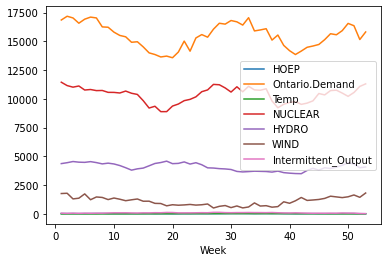

In [164]:
df_average_weekly.plot()

By comparison:

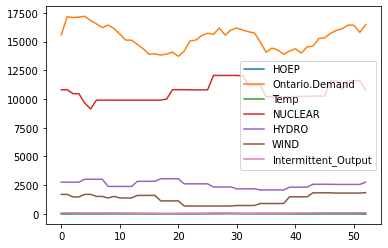

In [177]:
df_outlook[['HOEP'] + independ_vars][:53].plot()

Historical average price vs. realized price:

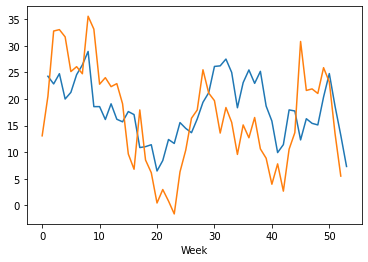

In [150]:
df_average_weekly['HOEP'].plot()
df_outlook['HOEP'][:53].plot()

The corresponding variables are in the same magnitude.

## Transform weekly outlook into hourly by scaling the hourly average

### Calculate the scale

In [178]:
print(df_outlook.shape)
print(df_average_weekly.shape)

(79, 9)
(53, 7)


In [180]:
df_average_weekly.head(1)

,HOEP,Ontario.Demand,Temp,NUCLEAR,HYDRO,WIND,Intermittent_Output
Week,,,,,,,
1,24.272113,16848.474702,-5.723958,11440.293155,4367.267857,1765.403274,60.581845


In [179]:
df_outlook.head(1)

,Date (week ending),HOEP,Ontario.Demand,Temp,NUCLEAR,HYDRO,WIND,Intermittent_Output,Week
0,2019-01-06 23:00:00,13.066012,15577.110789,-4.533333,10800,2756,1693.698047,78.546684,1


In [181]:
df_outlook_scale = df_outlook.copy()

In [183]:
for i, row in df_outlook_scale.iterrows():
    week = row['Week']
    for var in df_average_weekly.columns:
        df_outlook_scale[var+'_scale'] = row[var] / df_average_weekly.loc[week, var]

In [184]:
df_outlook_scale

,Date (week ending),HOEP,Ontario.Demand,Temp,NUCLEAR,HYDRO,WIND,Intermittent_Output,Week,HOEP_scale,Ontario.Demand_scale,Temp_scale,NUCLEAR_scale,HYDRO_scale,WIND_scale,Intermittent_Output_scale
0,2019-01-06 23:00:00,13.066012,15577.110789,-4.533333,10800,2756,1693.698047,78.546684,1,0.993943,0.96353,1.063317,0.923908,0.587817,1.457097,0.522246
1,2019-01-13 23:00:00,20.495655,17161.831644,-7.480952,10815,2756,1693.698047,78.870922,2,0.993943,0.96353,1.063317,0.923908,0.587817,1.457097,0.522246
2,2019-01-20 23:00:00,32.777738,17094.188987,-5.152381,10463,2756,1473.056923,78.870922,3,0.993943,0.96353,1.063317,0.923908,0.587817,1.457097,0.522246
3,2019-01-27 23:00:00,33.042917,17129.526494,-5.433333,10463,2756,1473.056923,78.870922,4,0.993943,0.96353,1.063317,0.923908,0.587817,1.457097,0.522246
4,2019-02-03 23:00:00,31.676548,17207.554596,-5.000000,9649,3010,1693.698047,74.438802,5,0.993943,0.96353,1.063317,0.923908,0.587817,1.457097,0.522246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,2020-06-07 23:00:00,11.187560,14970.400731,20.947619,9627,2611,741.360842,51.106821,23,0.993943,0.96353,1.063317,0.923908,0.587817,1.457097,0.522246
75,2020-06-14 23:00:00,5.162381,14991.931807,20.595238,9627,2611,741.360842,51.106821,24,0.993943,0.96353,1.063317,0.923908,0.587817,1.457097,0.522246
76,2020-06-21 23:00:00,13.651845,15397.115076,21.747619,10395,2611,741.360842,51.106821,25,0.993943,0.96353,1.063317,0.923908,0.587817,1.457097,0.522246
77,2020-06-28 23:00:00,13.430060,15745.074837,22.552381,10395,2611,741.360842,51.106821,26,0.993943,0.96353,1.063317,0.923908,0.587817,1.457097,0.522246


### Expand to hourly  
Do it week by week:

In [220]:
list_dfs_outlook_hourly = [None]*len(df_outlook_scale)

In [187]:
df_average.head(2)

HOEP  Ontario.Demand  Temp   NUCLEAR     GAS    HYDRO  \
Month Day Hour                                                            
1     1   0     13.370        14631.50 -4.95  11503.75  923.25  3193.50   
          1     10.295        14161.25 -5.10  11461.00  822.75  3178.75   

                   WIND  SOLAR  BIOFUEL  Week  
Month Day Hour                                 
1     1   0     1796.00    0.0     6.75     1  
          1     1715.75    0.0     6.25     1

In [188]:
df_average.columns

Index(['HOEP', 'Ontario.Demand', 'Temp', 'NUCLEAR', 'GAS', 'HYDRO', 'WIND',
       'SOLAR', 'BIOFUEL', 'Week'],
      dtype='object')

In [221]:
import copy
for i, row in df_outlook_scale.iterrows():
    week = row.Week
    df_outlook_hourly_ithWeek = df_average[df_average.Week==week].copy()
    for var in ['Ontario.Demand', 'Temp', 'NUCLEAR', 'HYDRO', 'WIND']:
        df_outlook_hourly_ithWeek[var + '_scaled'] = df_outlook_hourly_ithWeek[var]*row[var+'_scale']
    for var in ['SOLAR', 'BIOFUEL']:
        df_outlook_hourly_ithWeek[var + '_scaled'] = df_outlook_hourly_ithWeek[var]*row['Intermittent_Output_scale']
    
    list_dfs_outlook_hourly[i] = df_outlook_hourly_ithWeek.copy()

In [224]:
df_outlook_hourly_scaled = pd.concat(list_dfs_outlook_hourly)

In [227]:
cols = ['Week','HOEP',
        'Ontario.Demand_scaled',
        'Temp_scaled',
        'NUCLEAR_scaled',
        'HYDRO_scaled',
        'WIND_scaled',
        'SOLAR_scaled',
        'BIOFUEL_scaled',
        'Ontario.Demand',
        'Temp',
        'NUCLEAR',
        'GAS',
        'HYDRO',
        'WIND',
        'SOLAR',
        'BIOFUEL']

In [228]:
df_outlook_hourly_scaled = df_outlook_hourly_scaled[cols]

In [235]:
df_outlook_hourly_scaled.rename(columns = {'Ontario.Demand': 'Ontario.Demand_history', 'Temp': 'Temp_history',
                                          'NUCLEAR': 'NUCLEAR_history', 'GAS': 'GAS_history', 'HYDRO': 'HYDRO_history',
                                          'WIND': 'WIND_history', 'SOLAR': 'SOLAR_history', 'BIOFUEL': 'BIOFUEL_history'},
                               inplace=True)

In [236]:
df_outlook_hourly_scaled

Week     HOEP  Ontario.Demand_scaled  Temp_scaled  \
Month Day Hour                                                      
1     1   0        1  13.3700           14097.895923    -5.263421   
          1        1  10.2950           13644.795724    -5.422919   
          2        1  22.3425           13262.033249    -5.768497   
          3        1  12.5950           13062.582444    -5.821663   
          4        1   2.4775           12939.250545    -5.635582   
...              ...      ...                    ...          ...   
7     8   19      27  23.3125           16997.640842    22.728409   
          20      27  24.6525           16748.809101    22.117002   
          21      27  20.3425           15893.434935    21.984087   
          22      27   9.5750           14631.691798    20.761272   
          23      27   4.0175           13571.808292    20.415694   

                NUCLEAR_scaled  HYDRO_scaled  WIND_scaled  SOLAR_scaled  \
Month Day Hour                                                            
1     1   0       10628.402160   1877.194485  2616.945728      0.000000   
          1       10588.905109   1868.524180  2500.013715      0.000000   
          2       10563.035696   1874.843216  2211.144288      0.000000   
          3       10428.145185   1833.989915  2204.587353      0.000000   
          4       10363.933607   1749.932044  2320.062269      0.000000   
...                        ...           ...          ...           ...   
7     8   19      10475.726427   2686.324972   593.038369      1.305616   
          20      10479.884012   2607.263548   698.677882      0.000000   
          21      10480.576942   2390.358971   753.319010      0.000000   
          22      10492.125787   2130.102870   799.581831      0.000000   
          23      10439.925007   1897.033319   979.169003      0.000000   

                BIOFUEL_scaled  Ontario.Demand_history  Temp_history  \
Month Day Hour                                                         
1     1   0           3.525164                14631.50        -4.950   
          1           3.264040                14161.25        -5.100   
          2           3.786287                13764.00        -5.425   
          3           3.916848                13557.00        -5.475   
          4           3.133479                13429.00        -5.300   
...                        ...                     ...           ...   
7     8   19         24.023337                17641.00        21.375   
          20         21.020420                17382.75        20.800   
          21         20.889858                16495.00        20.675   
          22         13.578408                15185.50        19.525   
          23         13.578408                14085.50        19.200   

                NUCLEAR_history  GAS_history  HYDRO_history  WIND_history  \
Month Day Hour                                                              
1     1   0            11503.75       923.25        3193.50       1796.00   
          1            11461.00       822.75        3178.75       1715.75   
          2            11433.00       785.25        3189.50       1517.50   
          3            11287.00       787.00        3120.00       1513.00   
          4            11217.50       776.50        2977.00       1592.25   
...                         ...          ...            ...           ...   
7     8   19           11338.50      1768.00        4570.00        407.00   
          20           11343.00      1719.75        4435.50        479.50   
          21           11343.75      1278.75        4066.50        517.00   
          22           11356.25       663.75        3623.75        548.75   
          23           11299.75       518.50        3227.25        672.00   

                SOLAR_history  BIOFUEL_history  
Month Day Hour                                  
1     1   0               0.0             6.75  
          1               0.0             6.25  
       

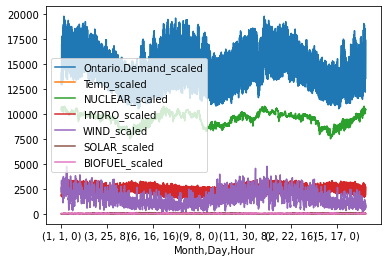

In [242]:
df_outlook_hourly_scaled.loc[:,'Ontario.Demand_scaled': 'BIOFUEL_scaled'].plot()

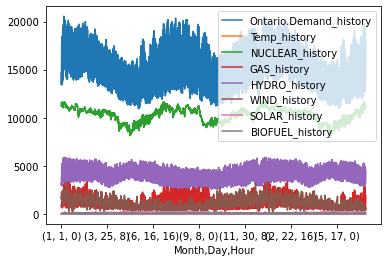

In [243]:
df_outlook_hourly_scaled.loc[:,'Ontario.Demand_history': 'BIOFUEL_history'].plot()

In [244]:
df_outlook_hourly_scaled.to_csv(os.path.join(dir_data_processed, 'hourly_outlook_12012018_from_HistoryAverageScaledByWeeklyOutlook.csv'))

## Format transform

In [245]:
target_cols = ['Date (week ending)', 'HOEP', 'Ontario ED', 'Normal Average Temperature (Â°C)', 'Expected Nuclear Output', 'Expected Hydro Output', 'Expected Wind Output', 'Expected Self-Scheduling & Intermittent Output']

In [ ]:
df_outlook_hourly_scaled[]